In [1]:
import numpy as np  # Import the NumPy library for working with arrays and computations.
from keras.datasets import mnist, fashion_mnist  # Import the mnist and fashion_mnist datasets from the Keras library.
import random  # Import the module for working with random numbers.
import numpy as np  # Import the NumPy library for working with arrays and mathematical operations.
import matplotlib.pyplot as plt  # Import the module for displaying images and plots.

In [2]:
def vectorized_result(j):
    e = np.zeros((10, 1))  # Create an array of zeros with a size of (10, 1).
    e[j] = 1.0  # Set one to the position corresponding to the value 'j'.
    return e  # Return the one-hot encoded result vector.

def load_data_wrapper():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()  # Load training and test data from fashion_mnist.

    # Transform and normalize training data
    training_inputs = [np.reshape(x, (784, 1)) / 255.0 for x in x_train]  # Transform and normalize training data.
    training_results = [vectorized_result(y) for y in y_train]  # Create result vectors for training labels.
    training_data = list(zip(training_inputs, training_results))  # Pairs of (input data, result vectors) in list format.

    # Test data does not require transformation, only normalization
    test_inputs = [np.reshape(x, (784, 1)) / 255.0 for x in x_test]  # Normalize test data.
    test_data = list(zip(test_inputs, y_test))  # Pairs of (input data, labels) in list format.

    return (training_data, test_data)  # Return training and test data as a tuple.

In [3]:
# Rectified Linear Unit (ReLU) activation function.
def ReLu(z):
    # Returns the value of z if it's greater than 0, otherwise returns 0.
    return np.maximum(0, z)

# Derivative of the ReLU activation function.
def ReLu_prime(z):
    # Returns 1 if z is greater than 0, otherwise returns 0.
    return np.where(z > 0, 1, 0)

# Softmax activation function.
def Softmax(z):
    # Computes probabilities for each class based on the input vector z.
    exp_z = np.exp(z - np.max(z))  # Subtract the maximum value for numerical stability.
    return exp_z / exp_z.sum(axis=0, keepdims=True)  # Return normalized class probabilities.

# Function to select random images from a data array.
def select_random_images(data, num_images=2):
    return random.sample(data, num_images)

# Function to display images along with their predicted classifications.
def display_images_with_classification(images, network):
    # images - a list of (image, label) pairs, network - the network used for classification.
    for image, label in images:
        # Get the predicted classification from the network.
        classification = np.argmax(network.feedforward(image))

        # Display the image and classification information.
        plt.imshow(np.reshape(image, (28, 28), 'F'), cmap='gray')
        plt.title(f"Image Label: {label}, Predicted Label: {classification}")
        plt.show()

# Class Network that inherits properties from the Network class.
class Network(object):

    def __init__(self, sizes):
        self.num_layers = len(sizes)  # Determine the number of layers in the network.
        self.sizes = sizes  # Store the sizes of each layer.

        # Initialize random biases for each neuron except the input layer.
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]  
        # Initialize random weights scaled for ReLU.
        self.weights = [np.random.randn(y, x) * np.sqrt(2. / x) for x, y in zip(sizes[:-1], sizes[1:])]  

    def feedforward(self, a):
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            a = ReLu(np.dot(w, a) + b)  # Compute activation using ReLU for each layer except the output layer.
        a = Softmax(np.dot(self.weights[-1], a) + self.biases[-1])  # Use softmax for the output layer.
        return a

    def backprop(self, x, y):
        # Function for backpropagation of error in a neural network.

        # Initialize gradients for biases and weights with zeros.
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x  # Initial activation is the input image.
        activations = [x]  # List to store activations for each layer.
        zs = []  # List to store weighted inputs for each layer.

        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b  # Compute the weighted input.
            zs.append(z)  # Store the weighted input.
            activation = ReLu(z)  # Compute activation using ReLU.
            activations.append(activation)  # Store the activation.

        delta = self.cost_derivative(activations[-1], y) * ReLu_prime(zs[-1])  # Compute delta for the output layer.
        nabla_b[-1] = delta  # Store delta for biases of the output layer.
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())  # Store delta for weights of the output layer.

        for l in range(2, self.num_layers):
            z = zs[-l]  # Get the weighted input for the current layer.
            rp = ReLu_prime(z)  # Compute the ReLU derivative for the current layer.
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * rp  # Compute delta for the current layer.
            nabla_b[-l] = delta  # Store delta for biases of the current layer.
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())  # Store delta for weights of the current layer.

        return (nabla_b, nabla_w)  # Return gradients for biases and weights.

    def update_mini_batch(self, mini_batch, eta):
        # Update weights and biases for a mini-batch using gradient descent.

        nabla_b = [np.zeros(b.shape) for b in self.biases]  # Initialize gradients for biases with zeros.
        nabla_w = [np.zeros(w.shape) for w in self.weights]  # Initialize gradients for weights with zeros.

        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)  # Compute gradients using backpropagation.
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]  # Update gradients for biases.
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]  # Update gradients for weights.

        # Update weights and biases in the network.
        self.weights = [w - (eta / len(mini_batch)) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        # Stochastic Gradient Descent method for training the network.

        training_data = list(training_data)  # Convert training data to a list.
        n = len(training_data)  # Determine the number of samples in the training data.

        if test_data:  # If there is test data available.
            test_data = list(test_data)  # Convert test data to a list.
            n_test = len(test_data)  # Determine the number of samples in the test data.

        for j in range(epochs):  # Loop over each epoch.
            random.shuffle(training_data)  # Shuffle the training data.
            mini_batches = [training_data[k:k + mini_batch_size] for k in range(0, n, mini_batch_size)]  # Split the training data into mini-batches.

            for mini_batch in mini_batches:  # Loop over each mini-batch.
                self.update_mini_batch(mini_batch, eta)  # Update weights and biases for this mini-batch.

            # If there is test data, print results at each epoch.
            if test_data:
                print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def evaluate(self, test_data):
        # Evaluate the network's progress.

        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]

        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        # Compute the partial derivatives of the cost function with respect to the output activations of the last layer.
        return output_activations - y


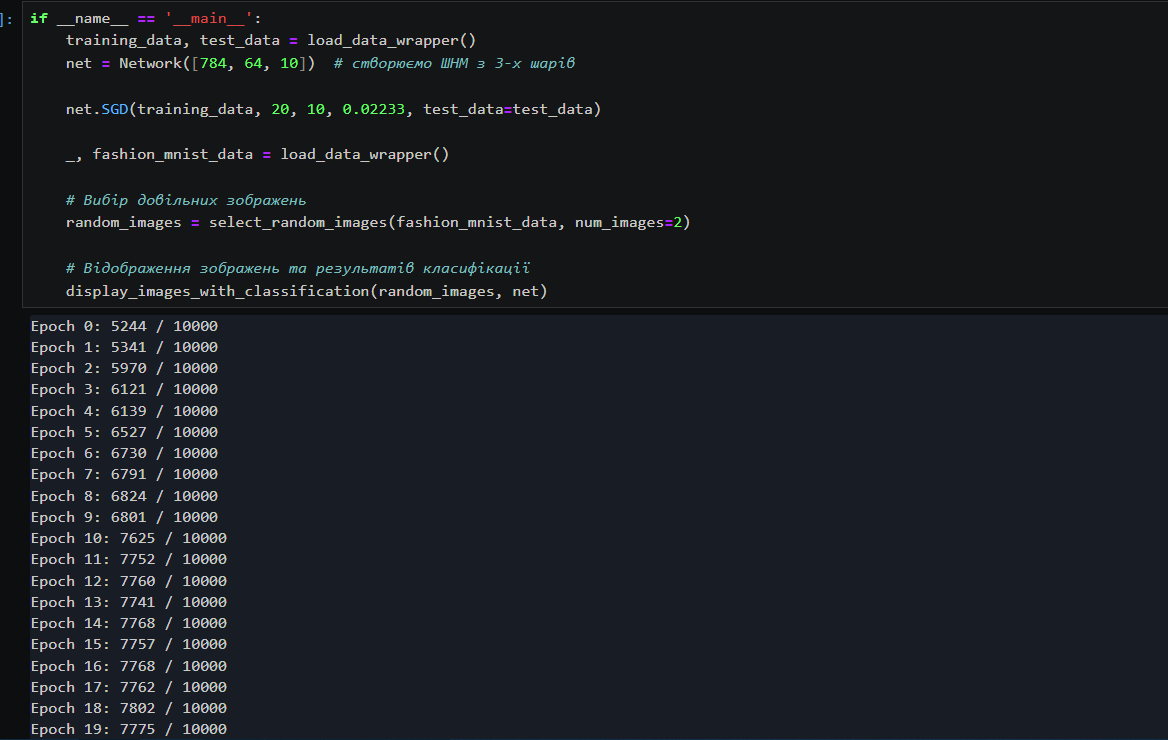

Epoch 0: 3117 / 10000
Epoch 1: 3672 / 10000
Epoch 2: 4636 / 10000
Epoch 3: 4695 / 10000
Epoch 4: 4716 / 10000


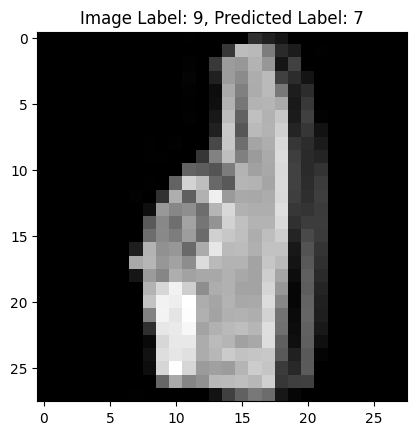

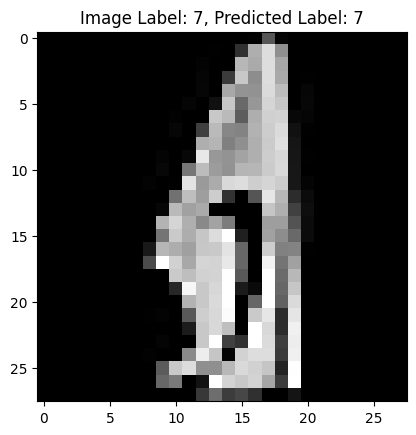

In [6]:
if __name__ == '__main__':
    training_data, test_data = load_data_wrapper()
    net = Network([784, 64, 10])  # створюємо ШНМ з 3-х шарів

    net.SGD(training_data, 5, 10, 0.02093, test_data=test_data)

    _, fashion_mnist_data = load_data_wrapper()

    # Вибір довільних зображень
    random_images = select_random_images(fashion_mnist_data, num_images=2)

    # Відображення зображень та результатів класифікації
    display_images_with_classification(random_images, net)